# Base Model QED
This is the base setup for working on QED data.
It shows how to import the data and how to convert the expressions into different formats.

In [1]:
from icecream import ic
import sympy as sp
from itertools import (takewhile,repeat)
from tqdm import tqdm
import numpy as np
import sys
import importlib.util

In [4]:
spec = importlib.util.spec_from_file_location("SympyPrefix", "../sympy-prefix/source/SympyPrefix.py")
SympyPrefix = importlib.util.module_from_spec(spec)
sys.modules["SympyPrefix"] = SympyPrefix
spec.loader.exec_module(SympyPrefix)
prefix_to_sympy = SympyPrefix.prefix_to_sympy
sympy_to_prefix = SympyPrefix.sympy_to_prefix
sympy_to_hybrid_prefix = SympyPrefix.sympy_to_hybrid_prefix
hybrid_prefix_to_sympy = SympyPrefix.hybrid_prefix_to_sympy

spec = importlib.util.spec_from_file_location("sp2tree", "../data-preprocessing/tree/sympy_to_tree.py")
sp2tree = importlib.util.module_from_spec(spec)
sys.modules["SympyTree"] = sp2tree
spec.loader.exec_module(sp2tree)

spec = importlib.util.spec_from_file_location("symba_utilities", "../conversions.py")
symba_utilities = importlib.util.module_from_spec(spec)
sys.modules["symba_utilities"] = symba_utilities
# spec.loader.exec_module(utilities)

In [11]:
def rawincount(filename):
    """count numer of lines in a file. 
    From https://stackoverflow.com/questions/845058/how-to-get-line-count-of-a-large-file-cheaply-in-python
    """
    f = open(filename, 'rb')
    bufgen = takewhile(lambda x: x, (f.raw.read(1024*1024) for _ in repeat(None)))
    return sum( buf.count(b'\n') for buf in bufgen )

def load_raw_amplitudes(filename, max_lines=-1):
    """
    Loading raw amplitudes from filename.
    
    Options:
        - `max_lines`: maximum number of lines to read
    """
    print("Loading amplitudes from "+ filename)
    if max_lines > 0:
        number_of_lines = max_lines
    else:
        number_of_lines = rawincount(filename)
    data = [0 for i in range(number_of_lines-1)]
    pbar = tqdm(total=number_of_lines)
    with open(filename) as f:
        line = f.readline()
        data.append(line)
        ctr = 0
        while line:
            line = f.readline()
            data[ctr] = line 
            pbar.update(1)
            ctr = ctr + 1
            if ctr >= number_of_lines:
                break
    pbar.close()
    return data


def load_squared_amplitudes(filename, max_lines=-1):
    """
    Loading squared amplitudes from filename and parsing into sympy.
    All squared amplitudes should be exportet from sympy and thus be readable
    without any preprocessing.

    Options:
        - `max_lines`: maximum number of lines to read

    Returns:
        list of squared amplitudes, each as a sympy expression
    """
    print("Loading squared amplitudes from "+ filename)
    if max_lines > 0:
        number_of_lines = max_lines
    else:
        number_of_lines = rawincount(filename)
    data = [0 for i in range(number_of_lines-1)]
    pbar = tqdm(total=number_of_lines)
    with open(filename) as f:
       line = f.readline()
       data.append(line)
       ctr = 0
       while line:
            line = f.readline()
            if line != "":
               line_sp = sp.sympify(line)
               data[ctr] = line_sp
            pbar.update(1)
            ctr = ctr + 1
            if ctr >= number_of_lines:
                break
    pbar.close()
    return data


In [15]:
amplitudes_filename = "../raw_data.nosync/QED_amplitudes_TreeLevel_2to2.txt"
sqamplitudes_filename = "../raw_data.nosync/QED_sqamplitudes_TreeLevel_2to2.txt"
max_lines = 200
amplitudes = load_raw_amplitudes(amplitudes_filename, max_lines=max_lines)
sqamplitudes = load_squared_amplitudes(sqamplitudes_filename, max_lines=max_lines)

Loading amplitudes from ../raw_data.nosync/QED_amplitudes_TreeLevel_2to2.txt


100%|██████████| 200/200 [00:00<00:00, 372000.35it/s]


Loading squared amplitudes from ../raw_data.nosync/QED_sqamplitudes_TreeLevel_2to2.txt


100%|██████████| 200/200 [00:00<00:00, 1463.11it/s]


In [16]:
# the amplitudes are in prefix format
amplitudes[0]

'Prod,1/2,Prod,i,Prod,Pow,e,2,Prod,Pow,Sum,Pow,m_e,2,Sum,Prod,-1,s_23,Prod,1/2,reg_prop,-1,Prod,gamma,alpha_4,alpha_2,alpha_0,Prod,gamma,alpha_4,alpha_3,alpha_1,Prod,ee,i_0,alpha_1,(p_1)_u,Prod,ee,i_2,alpha_0,(p_2)_u,Prod,ee^(*),i_3,alpha_2,(p_3)_u,ee^(*),i_1,alpha_3,(p_4)_u\n'

In [18]:
# the squared amplitudes are in sympy format
sqamplitudes[0]

4*e**4*(2*m_e**4 + m_e**2*(-s_14 - s_23) + s_12*s_34 + s_13*s_24)/(2*m_e**2 + reg_prop - 2*s_23)**2

In [25]:
# convert squared ampmlitudes to prefix
sqampl_prefix = [sympy_to_prefix(a) for a in sqamplitudes]
np.array(sqampl_prefix[0])

array(['mul', '4', 'mul', 'pow', 'e', '4', 'mul', 'pow', 'add',
       'reg_prop', 'add', 'mul', 's-', '2', 's_23', 'mul', '2', 'pow',
       'm_e', '2', 's-', '2', 'add', 'mul', '2', 'pow', 'm_e', '4', 'add',
       'mul', 's_12', 's_34', 'add', 'mul', 's_13', 's_24', 'mul', 'pow',
       'm_e', '2', 'add', 'mul', 's-', '1', 's_14', 'mul', 's-', '1',
       's_23'], dtype='<U8')

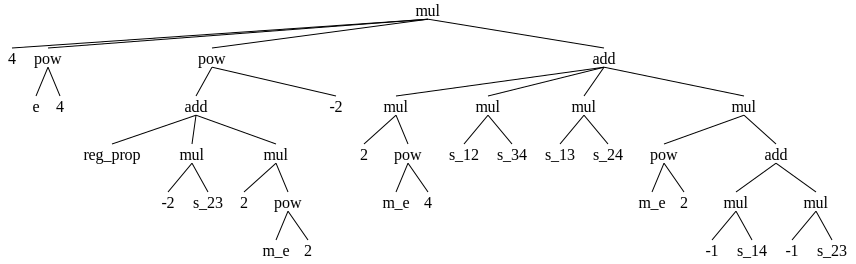

In [31]:
# convert squared amplitudes to trees:
sqampl_tree = [sp2tree.sympy_to_tree(a) for a in sqamplitudes]
sqampl_tree[0]